In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_final = pd.read_csv("../data/df_final.csv")

## Regression (Base Model)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [4]:
lineardf = df_final.dropna(subset=['logallexports'])
lineardf['IdealPointDistance_flipped'] = -1 * lineardf['IdealPointDistance']
lx = lineardf[['IdealPointDistance_flipped', 'distcap', 'pop_d']]
ly = lineardf[['logallexports']]

X_train, X_test, y_train, y_test = train_test_split(lx, ly, test_size=0.2, random_state=25)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred):.3f}")

basemodel = sm.OLS(ly, sm.add_constant(lx)).fit()
print(basemodel.summary())

# Issue: IdealPointDistance should not be positively correlated with tradeflow/exports

R² Score: 0.329
RMSE: 5.262
                            OLS Regression Results                            
Dep. Variable:          logallexports   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     673.2
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:44:38   Log-Likelihood:                -9647.7
No. Observations:                4272   AIC:                         1.930e+04
Df Residuals:                    4268   BIC:                         1.933e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

C:\Users\Admin\AppData\Local\Temp\ipykernel_8392\3354767641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineardf['IdealPointDistance_flipped'] = -1 * lineardf['IdealPointDistance']


## Regression

In [5]:
lx = lineardf[['distcap', 'contig', 'comlang_off', 'comrelig', 'pop_d', 'gdpcap_d', 'fta_wto', 'arms', 'IdealPointDistance_flipped']]
ly = lineardf[['logallexports']]

X_train, X_test, y_train, y_test = train_test_split(lx, ly, test_size=0.2, random_state=25)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred):.3f}")

lmodel = sm.OLS(ly, sm.add_constant(lx)).fit()
print(lmodel.summary())

# Still positive correlation with IdealPointDistance and tradeflow/export

R² Score: 0.464
RMSE: 4.203
                            OLS Regression Results                            
Dep. Variable:          logallexports   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     422.0
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:44:40   Log-Likelihood:                -9114.3
No. Observations:                4272   AIC:                         1.825e+04
Df Residuals:                    4262   BIC:                         1.831e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [6]:
lineardf.select_dtypes(include='number').corr()['IdealPointDistance']

year                         -0.088797
contig                       -0.034972
distcap                       0.023961
dist                          0.023354
comlang_off                   0.007244
comlang_ethno                 0.009273
comrelig                     -0.223439
pop_o                        -0.086443
pop_d                         0.058083
gdp_o                        -0.082262
gdp_d                         0.489059
gdpcap_o                     -0.078595
gdpcap_d                      0.544818
fta_wto                       0.060975
tradeflow_comtrade_o          0.299386
tradeflow_comtrade_d          0.375742
tradeflow_imf_o               0.300088
tradeflow_imf_d               0.375104
IdealPointDistance            1.000000
arms                          0.487706
tot_o                         0.077683
tot_d                        -0.005459
tgdp_ratio_o                 -0.003066
tgdp_ratio_d                 -0.028069
avgtradeflow                  0.332543
logtradeflow             

## XGBoost

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
XGBoost RMSE: 0.448


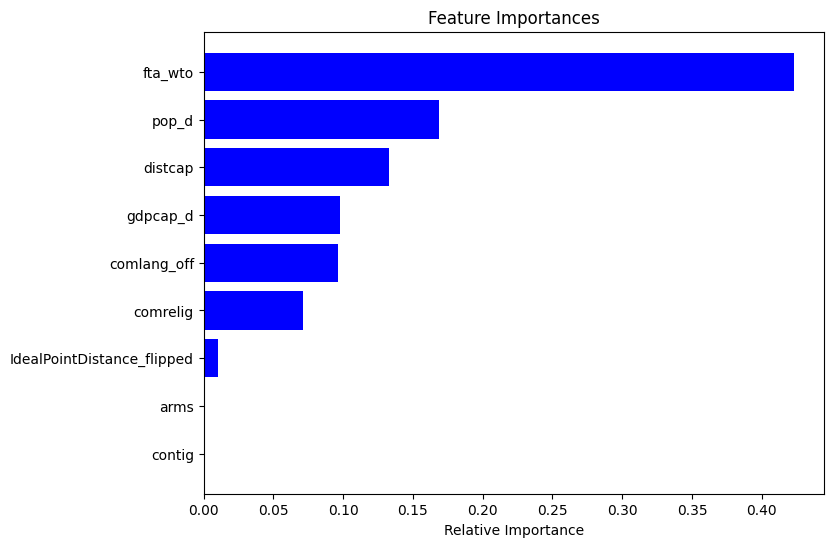

In [8]:
xgb_model = xgb.XGBRegressor(random_state=25)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train best model and evaluate
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(f"XGBoost RMSE: {mean_squared_error(y_test, y_pred):.3f}")

importances = best_xgb.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Cons: cannot see sign of IdealPointDistance

## Neural Network

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Standardize data (important for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(lx)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, ly, test_size=0.2, random_state=42)

# Build a simple feedforward neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, verbose = 0, batch_size=32, validation_split=0.2)

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print(f"Neural Network MSE: {mse:.3f}")

27/27 [==============================] - 0s 564us/step - loss: 2.4722
Neural Network MSE: 2.472


## Panel ADL Model with Fixed Effects

In [80]:
from linearmodels.panel import PanelOLS, RandomEffects, compare
import statsmodels.api as sm

In [85]:
df_panel = df_final[['year', 'country_d', 'logallexports', 'IdealPointDistance']].sort_values(by=['country_d', 'year'])
df_panel.set_index(['country_d', 'year'], inplace=True)

df_panel['logallexports_lag1'] = df_panel.groupby(level=0)['logallexports'].shift(1)
df_panel['IdealPointDistance_lag1'] = df_panel.groupby(level=0)['IdealPointDistance'].shift(1)
df_panel = df_panel.dropna().copy()

In [110]:
# ADL(1, 1)
model_formula = ('logallexports ~ 1 + logallexports_lag1 + IdealPointDistance + IdealPointDistance_lag1')

# Fixed effects
fe_model = PanelOLS.from_formula(model_formula + ' + EntityEffects', data=df_panel)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

# Random effects
re_model = RandomEffects.from_formula(model_formula, data=df_panel)
re_results = re_model.fit()

print(compare({"Fixed Effects": fe_results, "Random Effects": re_results}))

                        Model Comparison                       
                                Fixed Effects    Random Effects
---------------------------------------------------------------
Dep. Variable                   logallexports     logallexports
Estimator                            PanelOLS     RandomEffects
No. Observations                         4061              4061
Cov. Est.                           Clustered        Unadjusted
R-squared                              0.4488            0.9471
R-Squared (Within)                     0.4488            0.3236
R-Squared (Between)                    0.8499            0.9971
R-Squared (Overall)                    0.8267            0.9471
F-statistic                            1056.1         2.423e+04
P-value (F-stat)                       0.0000            0.0000
=========================     ===============   ===============
Intercept                          -1.721e-16        -5.702e-17
                                    (-12

<Figure size 1000x600 with 0 Axes>

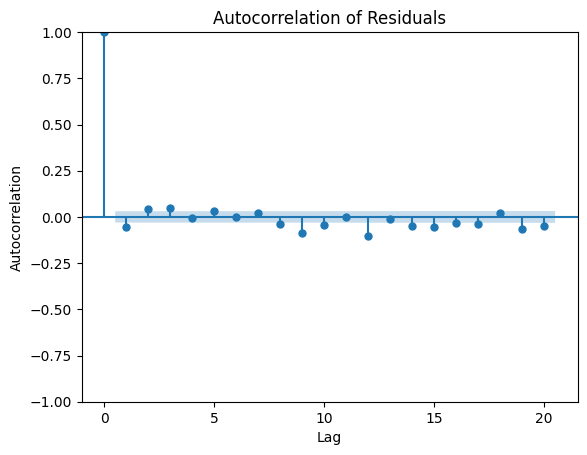

In [111]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(df_panel['residuals'], lags=20)
plt.title("Autocorrelation of Residuals")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [134]:
df_panel2 = df_final[['year', 'country_d', 'logallexports', 'IdealPointDistance', 'pop_d']].sort_values(by=['country_d', 'year'])
df_panel2.set_index(['country_d', 'year'], inplace=True)

df_panel2['logallexports_lag1'] = df_panel2.groupby(level=0)['logallexports'].shift(1)
df_panel2['IdealPointDistance_lag1'] = df_panel2.groupby(level=0)['IdealPointDistance'].shift(1)
df_panel2['logallexports_lag2'] = df_panel2.groupby(level=0)['logallexports'].shift(2)
df_panel2['IdealPointDistance_lag2'] = df_panel2.groupby(level=0)['IdealPointDistance'].shift(2)

df_panel2 = df_panel2.dropna()

vars_to_scale = ['logallexports', 'IdealPointDistance', 'logallexports_lag1', 'logallexports_lag2', 'IdealPointDistance_lag1', 'IdealPointDistance_lag2']
scaler = StandardScaler()
df_panel2[vars_to_scale] = scaler.fit_transform(df_panel2[vars_to_scale])
formula = ('logallexports ~ 1 + logallexports_lag1 + logallexports_lag2 '
           '+ IdealPointDistance + IdealPointDistance_lag1 + IdealPointDistance_lag2 '
           '+ EntityEffects')

fe_model = PanelOLS.from_formula(formula, data=df_panel2)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)

df_panel2['fitted'] = fe_results.predict().fitted_values
df_panel2['residuals'] = fe_results.resids

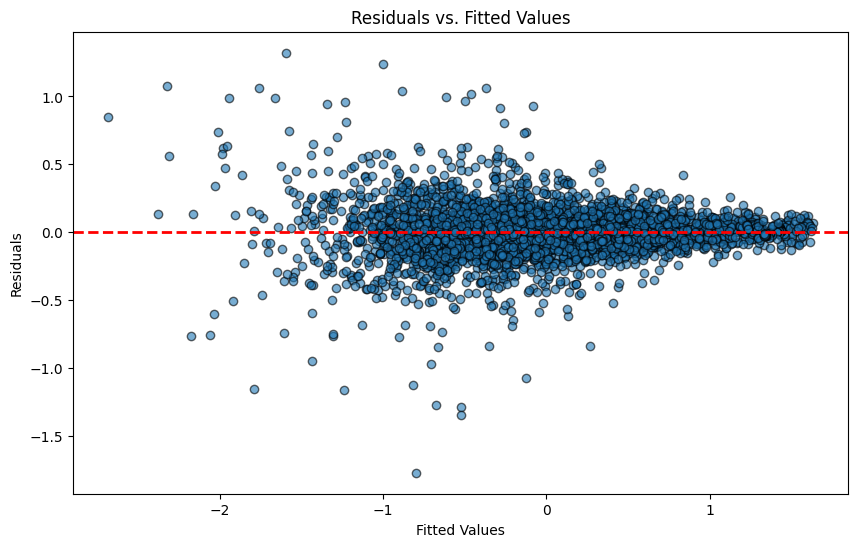

In [135]:
plt.figure(figsize=(10, 6))
plt.scatter(df_panel2['fitted'], df_panel2['residuals'], alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

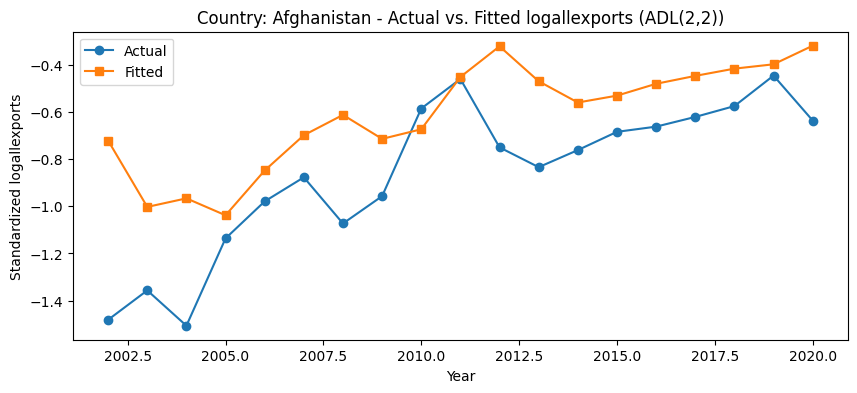

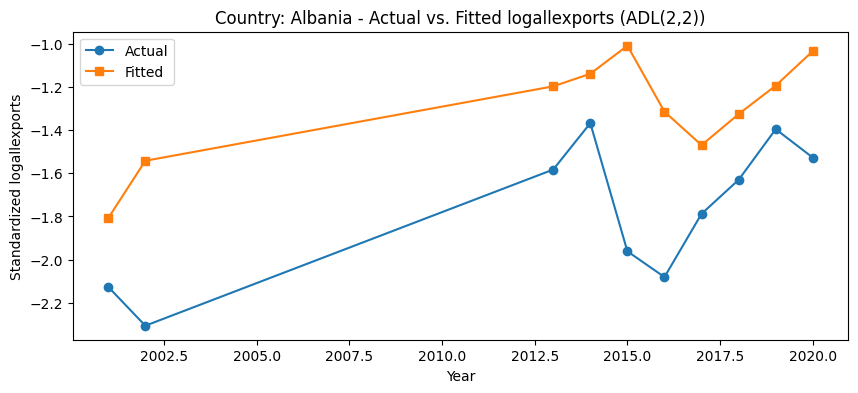

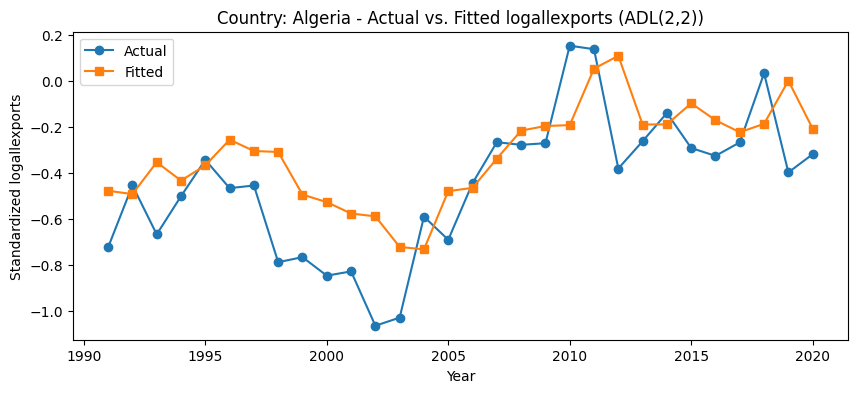

In [139]:
# selected_countries = ['China', 'United States of America', 'Malaysia']
selected_countries = df_panel.index.get_level_values(0).unique()[:3]
for country in selected_countries:
    if country in df_panel2.index.get_level_values(0):
        country_data = df_panel2.loc[country]
        plt.figure(figsize=(10, 4))
        plt.plot(country_data.index, country_data['logallexports'], marker='o', label='Actual')
        plt.plot(country_data.index, country_data['fitted'], marker='s', label='Fitted')
        plt.title(f"Country: {country} - Actual vs. Fitted logallexports (ADL(2,2))")
        plt.xlabel("Year")
        plt.ylabel("Standardized logallexports")
        plt.legend()
        plt.show()